# Understanding Customer Behaviors with Cohort Analysis and RFM Framwork

- Online Transaction Consumer Segmentation Analysis

**Problem**: Are we able to create distinguishing segments and design CRM campaigns accordingly to improve customer engagement and/or monetization?
<br>
<br>**Goal**: 1) Evaluate the healthy of customers' shopping habits; 2) Define the most valuable customers (MVC)
<br>Metrics: 1) **"Customer Retention Rate + Average Quantity"**, 2) **"RFM Segment + RFM Scores"**
<br>**Techniques & Tools**: Time cohort analysis, RFM segmentation Analysis
<br>**Challenges**: 
<br> 1. Need to pivot a cohort table as a base for further matrics calculation
<br> 2. What percentage of our customers are the most valuable customers?

<br>**Dataset**: The dataset I’m using is 20% random sample from a UK-based online retail dataset with half a million transactions. This is a realistic dataset between Dec 2010 to Dec 2011. The data contains 7 columns with the customer transactions. The main ones we will use are: date, price, and the customer ID.

## Import Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

In [2]:
online = pd.read_csv('/Users/jiehu/online.csv')

In [3]:
online.head(3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom


In [44]:
print('Min:{} ; Max:{}'.format(min(online.InvoiceDate),max(online.InvoiceDate)))

Min:2010-12-01 08:26:00 ; Max:2011-12-09 12:49:00


In [12]:
online.describe()

,Unnamed: 0,InvoiceNo,Quantity,UnitPrice,CustomerID
count,70864.000000,70864.000000,70864.000000,70864.000000,70864.00000
mean,278797.962590,560639.843136,11.511233,3.063033,15552.19790
std,153606.252964,13176.494003,41.017582,31.894970,1595.50593
min,3.000000,536365.000000,1.000000,0.001000,12747.00000
25%,147667.250000,549128.000000,2.000000,1.250000,14194.00000
50%,286056.000000,562012.500000,4.000000,1.950000,15525.00000
75%,412258.750000,572283.000000,12.000000,3.750000,16931.00000
max,541893.000000,581586.000000,4300.000000,8142.750000,18287.00000


In [6]:
online.isnull().sum()

Unnamed: 0     0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# I. Time Cohort Analysis

## Build a cohort table for time-based cohorts

In [7]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   70864 non-null  int64  
 1   InvoiceNo    70864 non-null  int64  
 2   StockCode    70864 non-null  object 
 3   Description  70864 non-null  object 
 4   Quantity     70864 non-null  int64  
 5   InvoiceDate  70864 non-null  object 
 6   UnitPrice    70864 non-null  float64
 7   CustomerID   70864 non-null  int64  
 8   Country      70864 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 4.9+ MB


*'InvoiceDate' variable is string format*

### 1. Transform to data format

In [8]:
# convert InvoiceDate column from string to datetime
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

In [9]:
# create a function that truncates 'InvoiceDate' to a first day of the month
# datetime.datetime() module shows the combination of a date and a time.
def get_month(x): return dt.datetime(x.year,x.month,1)

# create new column:'InvoiceMonth'
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)

In [10]:
online.head(3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01


### 2. Assign acquisition month cohort to each customer

Split - Split a table into groups

In [13]:
# call .groupby() and pass the name of the column you want to group on, here we want to groupby 'CustomerID'
# then, use ['InvoiceMonth'] to specify the columns on which we want to perform the actual operation
# use .transform() in conjunction with .groupby() to summarize data, here we want to assign the smallest InvoiceMonth value to each customer

grouping = online.groupby('CustomerID')['InvoiceMonth'].transform('min')

* while aggregation must return a reduced version of the data, .transform() can return some transformed version of the full data to recombine.
* group data in python https://realpython.com/pandas-groupby/#example-1-us-congress-dataset
* understand the Transform function in Pandas https://pbpython.com/pandas_transform.html

In [14]:
grouping

0       2011-04-01
1       2011-09-01
2       2011-07-01
3       2011-11-01
4       2011-02-01
           ...    
70859   2011-07-01
70860   2010-12-01
70861   2010-12-01
70862   2010-12-01
70863   2011-08-01
Name: InvoiceMonth, Length: 70864, dtype: datetime64[ns]

Apply and Combine - Apply operations (transform) to every sub-group that is produced by the splitting stage

In [16]:
online['CohortMonth'] = grouping
online.head(5)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01


### 3. Calculate the time offset

Extract integer values from data:

In [17]:
# define function to extract interger values from 'InvoiceMonth' and 'CohortMonth'
def get_date_int(df,column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year,month,day

# create two objects with year and month integer values from each of the 'InvoiceMonth' and 'CohortMonth' variables
invoice_year, invoice_month,_ = get_date_int(online,'InvoiceMonth')
cohort_year,cohort_month,_ = get_date_int(online,'CohortMonth')

Calculate the number of months between any transaction and the first transaction for each customer:

In [18]:
# calculate the differences in years and months between InvoiceMonth and CohortMonth
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# covert total differences to months
# "+1" in the end so the first month is marked as 1 instead of 0 for easier interpretation
online['CohortIndex'] = years_diff * 12 + months_diff + 1

online.head(3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1


*Now, the new column 'CohortIndex' is added!*

## Calculate Business Metrics 1 - Customer Retention Rate

### Step 1: Calculate the number of monthly active customers in each cohort

In [19]:
# split table into sub-tables
grouping = online.groupby(['CohortMonth','CohortIndex'])

In [21]:
grouping

In [22]:
# count number of unique customers in each group 
cohort_data = grouping['CustomerID'].apply(pd.Series.unique)

cohort_data.head(3)

CohortMonth  CohortIndex
2010-12-01   1              [14060, 16904, 14606, 14709, 12841, 16725, 175...
             2              [13093, 13869, 15498, 13174, 17787, 12748, 130...
             3              [15601, 18055, 14415, 14878, 16255, 15708, 142...
Name: CustomerID, dtype: object

In [23]:
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data

CohortMonth  CohortIndex
2010-12-01   1              716
             2              246
             3              221
             4              251
             5              245
                           ... 
2011-10-01   2               67
             3               30
2011-11-01   1              291
             2               32
2011-12-01   1               38
Name: CustomerID, Length: 91, dtype: int64

In [24]:
# reset the index of the DataFrame, and use the default one instead
cohort_data = cohort_data.reset_index()
# reshape data
# index is the feature that allows you to group your data
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                columns='CohortIndex',
                                values='CustomerID')
print(cohort_counts)

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   716.0  246.0  221.0  251.0  245.0  285.0  249.0  236.0  240.0   
2011-01-01   332.0   69.0   82.0   81.0  110.0   90.0   82.0   86.0  104.0   
2011-02-01   316.0   58.0   57.0   83.0   85.0   74.0   80.0   83.0   86.0   
2011-03-01   388.0   63.0  100.0   76.0   83.0   67.0   98.0   85.0  107.0   
2011-04-01   255.0   49.0   52.0   49.0   47.0   52.0   56.0   59.0   17.0   
2011-05-01   249.0   40.0   43.0   36.0   52.0   58.0   61.0   22.0    NaN   
2011-06-01   207.0   33.0   26.0   41.0   49.0   62.0   19.0    NaN    NaN   
2011-07-01   173.0   28.0   31.0   38.0   44.0   17.0    NaN    NaN    NaN   
2011-08-01   139.0   30.0   28.0   35.0   14.0    NaN    NaN    NaN    NaN   
2011-09-01   279.0   56.0   78.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   318.0   67.0   30.0    NaN    NaN    NaN    NaN    

The row values represent different cohorts. In this case it's the month of the first ever purchase. 
<br>The column values represent months since acquisition.
<br>The metrics in the table are the count of active customers. 

### Step2: Calculate a retention rate

In [31]:
# select the first column in cohort_counts table to get cohort sizes
cohort_sizes = cohort_counts.iloc[:,0]

# divide values in cohort_counts table by cohort_sizes
# use axis=0 parameter to ensure divide along the row axis
retention = cohort_counts.divide(cohort_sizes,axis=0)
# round the ration to 3 digits and multiply by a 100 to make it look like a percentage
retention.round(3) *100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,34.4,30.9,35.1,34.2,39.8,34.8,33.0,33.5,37.0,35.5,48.6,24.0
2011-01-01,100.0,20.8,24.7,24.4,33.1,27.1,24.7,25.9,31.3,30.7,37.3,13.6,NaN
2011-02-01,100.0,18.4,18.0,26.3,26.9,23.4,25.3,26.3,27.2,30.1,8.9,NaN,NaN
2011-03-01,100.0,16.2,25.8,19.6,21.4,17.3,25.3,21.9,27.6,9.8,NaN,NaN,NaN
2011-04-01,100.0,19.2,20.4,19.2,18.4,20.4,22.0,23.1,6.7,NaN,NaN,NaN,NaN
2011-05-01,100.0,16.1,17.3,14.5,20.9,23.3,24.5,8.8,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,15.9,12.6,19.8,23.7,30.0,9.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,16.2,17.9,22.0,25.4,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.6,20.1,25.2,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* We can now compare retention rate over time and across cohorts to evaluate the healthy of customers' shopping habits

## Calculate Business Metrics 2 _ Average quantity

In [27]:
# split table into sub-tables and applied average function to 'Quantity' column, store the results ad cohort_data
cohort_data = online.groupby(['CohortMonth','CohortIndex'])['Quantity'].mean()
cohort_data

CohortMonth  CohortIndex
2010-12-01   1              11.111588
             2              12.260241
             3              12.152314
             4              13.228676
             5              13.669839
                              ...    
2011-10-01   2               7.452211
             3               5.987654
2011-11-01   1               7.840920
             2               7.145455
2011-12-01   1              21.336538
Name: Quantity, Length: 91, dtype: float64

In [29]:
# reset the index before calling pivot function
cohort_data = cohort_data.reset_index()
avg_quantity = cohort_data.pivot(index='CohortMonth',
                                columns='CohortIndex',
                                values='Quantity')
avg_quantity.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.1,12.3,12.2,13.2,13.7,11.3,10.6,12.8,13.2,13.0,14.5,10.9,13.7
2011-01-01,10.9,10.8,10.0,10.1,14.3,13.2,17.4,16.4,18.7,10.2,10.7,13.2,NaN
2011-02-01,12.1,14.3,10.6,11.5,17.5,12.2,17.3,13.2,13.4,15.9,14.3,NaN,NaN
2011-03-01,9.6,14.2,13.0,10.2,16.1,12.7,11.6,11.5,9.0,9.6,NaN,NaN,NaN
2011-04-01,9.9,11.1,12.4,11.5,11.4,7.7,10.4,9.4,6.6,NaN,NaN,NaN,NaN
2011-05-01,14.1,9.6,15.3,11.6,11.9,8.5,9.8,7.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.6,16.1,18.1,11.2,12.4,7.2,9.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.9,16.4,5.6,10.1,6.2,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.5,7.4,5.5,5.7,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualization

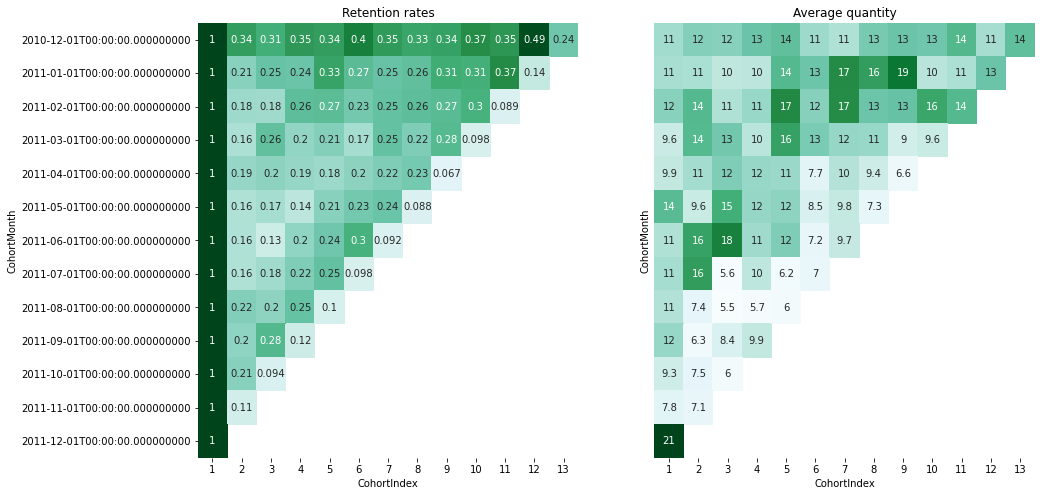

In [41]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)

# pre-define width and height in inches
sns.heatmap(data=retention,annot=True,
            cmap='BuGn',cbar=False,
            vmin=0.0,vmax=0.5) # vmin and vmas parameters are used to ensure the outliers don't impact the visualization
plt.title('Retention rates')

plt.subplot(1,2,2)

# pre-define width and height in inches
sns.heatmap(data=avg_quantity,annot=True,yticklabels=False,
            cmap='BuGn',cbar=False) # vmin and vmas parameters are used to ensure the outliers don't impact the visualization
plt.title('Average quantity')


plt.show()

1. The first column of retention rates will always be 100% as it the total size of each cohort month.
2. Customers that are retained in subsequent months purchase more products.
3. Compared to the customers who signed up in the last 6 months, those who signed up 12 months ago have higher retention rate while generally decreasing user engagement over lifetime.
4. The highest retention rate (49%) happened amongest Dec 2010 cohort after 11 months since first purchase. The average purchase quantity was reletively low (14).
5. The average quantity purchased by recent cohorts (2011-07, 2011-08, 2011-09, 2011-10, 2011-11) is lower than 'older' cohorts.
6. The average quantity purchased by the newest cohorts (2011-12) spikes at 21.

# II. RFM Segmentation

### 1. Data Preparation

In [45]:
# check timeframe in the current dataset
print('Min:{} ; Max:{}'.format(min(online.InvoiceDate),max(online.InvoiceDate)))

Min:2010-12-01 08:26:00 ; Max:2011-12-09 12:49:00


In [47]:
# create a hypothetical **snapshot_day** date as if we're doing analysis on the most recent data
# create the last InvoiceDate and add 1 more day
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

In [51]:
# create a new column 'TotalSum' for amount of each transaction
online['TotalSum'] = online['UnitPrice']*online['Quantity']
online.head(3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7,12.60
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3,1.45
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1,22.50


### 2. Calculate RFM values for each customer

In [52]:
# calculate Recency, Frequency and Monetary value

# aggregate data on a customer level
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo':'count',
    'TotalSum': 'sum'})

# rename columns for easier interpretation
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

datamart.head(3)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45


### 3. Assign RFM quartile values to each customer

In [53]:
# for Recency Score we give inverse labels as the more active the customer is the lower the value of Recency
r_labels = range(4,0,-1)
r_quartiles = pd.qcut(datamart['Recency'],q=4,labels=r_labels)

In [61]:
datamart['R'] = r_quartiles

In [59]:
f_labels = range(1,5)
f_quartile = pd.qcut(datamart['Frequency'],q=4,labels=f_labels)
datamart['F'] = f_quartile

In [60]:
m_labels = range(1,5)
m_quartile = pd.qcut(datamart['MonetaryValue'],q=4,labels=m_labels)
datamart['M'] = m_quartile

In [62]:
datamart.head(3)

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12747,2,27,992.82,4,4,4
12748,1,967,7522.06,4,4,4
12749,4,37,813.45,4,4,4


*All customers have a auartile value assigned and we'll use that to build the segmentation.*

### 4. Build RFM Segment

In [71]:
# concatenate RFM quartile values to 'RFN_segment'

# define a function that creates the concatenated list from RFM values converted to string
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

datamart['RFM_segment'] = datamart.apply(join_rfm, axis=1)

In [69]:
# sum RFM quartiles values to 'RFM_score'
# the higher the overall 'RFM_score the more valuable the customer
datamart['RFM_score'] = datamart[['R','F','M']].sum(axis=1)

In [147]:
datamart.head(3)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_score,RFM_segment
CustomerID,,,,,,,,
12747,2,27,992.82,4,4,4,12.0,444
12748,1,967,7522.06,4,4,4,12.0,444
12749,4,37,813.45,4,4,4,12.0,444


*Customers get 2 different metrics (RFM_score,RFM_segment) that we created.*

In [134]:
datamart.describe()

,Recency,Frequency,MonetaryValue,RFM_score
count,3701.000000,3701.000000,3701.000000,3701.000000
mean,94.298568,19.147257,380.535069,7.443394
std,99.974969,44.831615,1474.285937,2.825434
min,1.000000,1.000000,0.650000,3.000000
25%,19.000000,4.000000,59.400000,5.000000
50%,52.000000,9.000000,140.300000,7.000000
75%,151.000000,21.000000,337.800000,10.000000
max,374.000000,1532.000000,59596.070000,12.000000


# III. Insights based on analyzing RFM table

1. The lowest (111) and highest (444) rated RFM segments are among the largest ones. (Refer to Out[92])
2. There is positive correlations across Recency, Frequency, and Monetary Value based on the RFM segmentation results. (Refer to Out[91])
3. Each of the RFM values are better with the higher RFM score segment.(Refer to Out[91])
4. Our MVCs are those with a total RFM score of 12.(Refer to Out[91])
5. In real business world, we can set criteria/threshold on R/F/M values based on business needs and apply them to RFM metrics table to get a specific group of customers. [148]   

In [92]:
# investigate the size of the segment
datamart.groupby('RFM_segment').size().sort_values(ascending=False)[:10]

RFM_segment
444    382
111    346
211    168
344    162
233    132
222    130
311    120
433    119
333    118
122    116
dtype: int64

In [93]:
# select the lowest segmentation of 111
datamart[datamart['RFM_segment'] == '111'][:5]

,Recency,Frequency,MonetaryValue,R,F,M,RFM_score,RFM_segment
CustomerID,,,,,,,,
12837,173,2,10.55,1,1,1,3.0,111
12852,295,2,32.55,1,1,1,3.0,111
12902,265,4,42.03,1,1,1,3.0,111
12922,161,4,57.24,1,1,1,3.0,111
12929,312,3,42.90,1,1,1,3.0,111


In [131]:
datamart_summ = datamart.groupby('RFM_score').agg({
                                                'Recency':'mean',
                                                'Frequency':'mean',
                                                'MonetaryValue':['mean','count']}).round(1)
datamart_summ

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_score                                      
3.0         256.7       2.0          28.5   346
4.0         175.7       3.2          48.0   348
5.0         145.3       4.3          79.6   406
6.0         105.4       6.4         149.4   433
7.0          82.8       8.9         163.1   384
8.0          63.4      12.8         198.6   382
9.0          48.4      16.8         330.0   347
10.0         32.9      24.5         438.8   364
11.0         21.6      38.8         709.4   309
12.0          7.6      77.3        1709.0   382

The buckets we get are not so different from each other and there is a chance we can merge some segments

## Apply assumed business logic (criteria) to deliver business value

In [142]:
datamart2 = datamart.copy(deep=True)
datamart2.head(3)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_score,RFM_segment
CustomerID,,,,,,,,
12747,2,27,992.82,4,4,4,12.0,444
12748,1,967,7522.06,4,4,4,12.0,444
12749,4,37,813.45,4,4,4,12.0,444


In [155]:
# set criteria/threshold 
datamart2['last_order_within_30d'] = datamart2['Recency']<30 # Had transactions in the last 30 days
datamart2['more_than_5_orders'] = datamart2['Frequency']>5 # Logged in more than 5 times
datamart2["value_higher_than_200"] = datamart2["MonetaryValue"]>200 # Sum of value higher than 200

In [153]:
datamart2.groupby(["last_order_within_30d", "more_than_5_orders", "value_higher_than_200"]).count()

Recency  \
last_order_within_30d more_than_5_orders value_higher_than_200            
False                 False              False                      997   
                                         True                        93   
                      True               False                      729   
                                         True                       576   
True                  False              False                      188   
                                         True                        17   
                      True               False                      341   
                                         True                       760   

                                                                Frequency  \
last_order_within_30d more_than_5_orders value_higher_than_200              
False                 False              False                        997   
                                         True                          93   
                      True               False                        729   
                                         True                         576   
True                  False              False                        188   
                                         True                          17   
                      True               False                        341   
                                         True                         760   

                                                                MonetaryValue  \
last_order_within_30d more_than_5_orders value_higher_than_200                  
False                 False              False                            997   
                                         True                              93   
                      True               False                            729   
                                         True                             576   
True                  False              False                            188   
                                         True                              17   
                      True               False                            341   
                                         True                             760   

                                                                  R    F    M  \
last_order_within_30d more_than_5_orders value_higher_than_200                  
False                 False              False                  997  997  997   
                                         True                    93   93   93   
                      True               False                  729  729  729   
                                         True                   576  576  576   
True                  False              False                  188  188  188   
                                         True                    17   17   17   
                      True               False                  341  341  341   
                                         True                   760  760  760   

                                                                RFM_score  \
last_order_within_30d more_than_5_orders value_higher_than_200              
False                 False              False                        997   
                                         True                          93   
                      True               False                        729   
                                         True                         576   
True                  False              False                        188   
                                         True                          17   
                      True               False                        341   
                                         True                         760   

                                                                RFM_segment  \
last_order_within_30d more_than_5_orders value_higher_than_200        

### Based on the criteria/threshold above, five final segments (in the brackets you can find the segment sizes) are defined as:

1. **High Engagement & High Value (760)** are those who had their last transactions in the last 30 days, made more than 5 transactions, and contributed more than 200 on average.
2. **High Engagement & Low Value (341)** are those who are as active as Group1 but contributed less than 200.
3. **Recent Activity & Low Frequency (188)** are those who had their last transactions in the last 30 days but made no more than 5 transactions. These customers also have a lower monetary value.
4. **“Old” Activity & High Frequency (729+576)** are those who did not have any transactions in the last 30 days. However, on average they had more than 5 transactions. These customers were very active at the beginning of their journey but are not that active recently. We need to find ways to reengage them.
5. **Low Engagement & Low Value (997)** are those who did not have any transactions in the last 30 days, made no more than 5 transactions, and contributed the lowest revenue.

# END